In [126]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import mean_absolute_error, roc_curve, auc, roc_auc_score, recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer, make_blobs
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imblearn.over_sampling import SMOTE


import os 
os.chdir('e:/ml_data/kaggle_data/store_sales')

In [6]:
train = pd.read_csv('./train.csv', dtype={'StateHoliday': np.string_})
test = pd.read_csv('./test.csv', dtype={'StateHoliday': np.string_})
store = pd.read_csv('./store.csv')

In [42]:
test[test['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [38]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [58]:
train.groupby('DayOfWeek')['Open'].value_counts()

DayOfWeek  Open
1          1       137560
           0         7170
2          1       143961
           0         1703
3          1       141936
           0         3729
4          1       134644
           0        11201
5          1       138640
           0         7205
6          1       144058
           0          672
7          0       141137
           1         3593
Name: count, dtype: int64

In [61]:
test.fillna(1, inplace=True)

In [68]:
store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [69]:
v1 = 'CompetitionDistance'
v2 = 'CompetitionOpenSinceMonth'
v3 = 'CompetitionOpenSinceYear'
v4 = 'Promo2SinceWeek'
v5 = 'Promo2SinceYear'
v6 = 'PromoInterval'

In [75]:
store[(store[v2].isna()) & (store[v3].isna())]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.00,NaN,NaN,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
12,13,d,a,310.00,NaN,NaN,1,45.00,2009.00,"Feb,May,Aug,Nov"
15,16,a,c,3270.00,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.00,NaN,NaN,1,22.00,2011.00,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.00,NaN,NaN,1,22.00,2012.00,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.00,NaN,NaN,1,10.00,2014.00,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.00,NaN,NaN,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.00,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.00,NaN,NaN,0,NaN,NaN,NaN


In [76]:
store.fillna(0, inplace=True)
store.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

<Axes: title={'center': 'Store_1'}, xlabel='Date'>

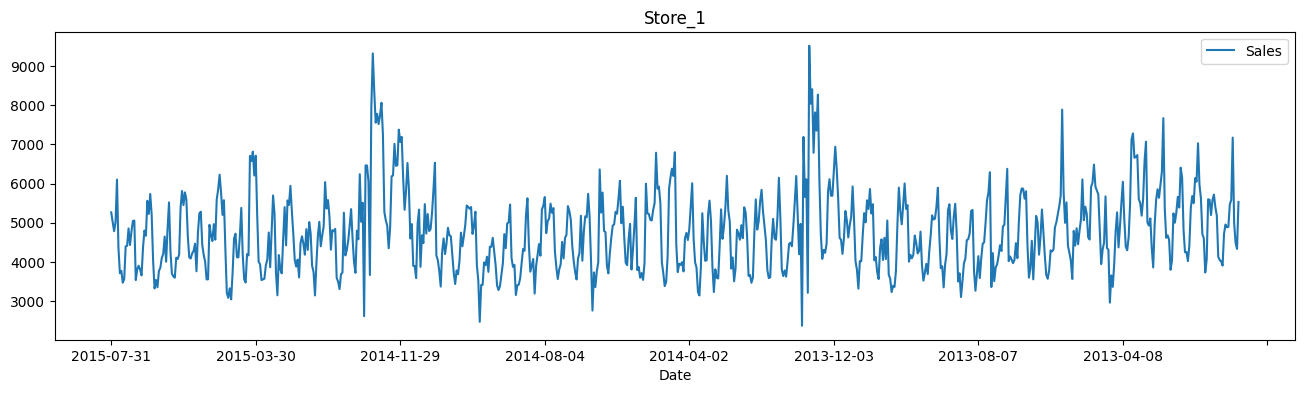

In [80]:
sale_data = train[train['Sales'] > 0]
sale_data.loc[train['Store'] == 1].plot(x='Date', y='Sales', title='Store_1', figsize=(16, 4))

<Axes: title={'center': 'Store_1'}, xlabel='Date'>

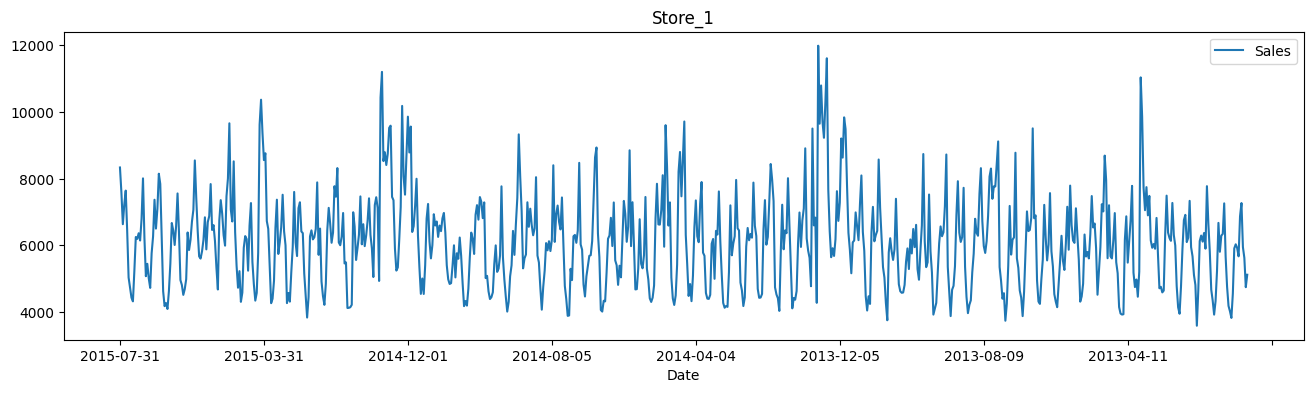

In [81]:
sale_data.loc[train['Store'] == 1024].plot(x='Date', y='Sales', title='Store_1', figsize=(16, 4))

In [82]:
test['Date'].unique()

array(['2015-09-17', '2015-09-16', '2015-09-15', '2015-09-14',
       '2015-09-13', '2015-09-12', '2015-09-11', '2015-09-10',
       '2015-09-09', '2015-09-08', '2015-09-07', '2015-09-06',
       '2015-09-05', '2015-09-04', '2015-09-03', '2015-09-02',
       '2015-09-01', '2015-08-31', '2015-08-30', '2015-08-29',
       '2015-08-28', '2015-08-27', '2015-08-26', '2015-08-25',
       '2015-08-24', '2015-08-23', '2015-08-22', '2015-08-21',
       '2015-08-20', '2015-08-19', '2015-08-18', '2015-08-17',
       '2015-08-16', '2015-08-15', '2015-08-14', '2015-08-13',
       '2015-08-12', '2015-08-11', '2015-08-10', '2015-08-09',
       '2015-08-08', '2015-08-07', '2015-08-06', '2015-08-05',
       '2015-08-04', '2015-08-03', '2015-08-02', '2015-08-01'],
      dtype=object)

In [85]:
cond = train['Sales'] > 0
train = train[cond]

train = pd.merge(train, store, on='Store', how='left')
test = pd.merge(test, store, on='Store', how='left')

In [ ]:
for data in [train, test]:
    data['year'] = data['Date'].apply(lambda x: x.split('-')[0]).astype(int)
    data['month'] = data['Date'].apply(lambda x: x.split('-')[1]).astype(int)
    data['day'] = data['Date'].apply(lambda x: x.split('-')[2]).astype(int)

    month2str = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    data['monthstr'] = data['month'].map(month2str)
    convert = lambda x: 0 if x['PromoInterval'] == 0 else 1 if x['monthstr'] in x['PromoInterval'] else 0
    data['IsPromoMonth'] = data.apply(convert, axis=1)

    mappings = {'0': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}
    data['StoreType'].replace(mappings, inplace=True)
    data['Assortment'].replace(mappings, inplace=True)
    data['StateHoliday'].replace(mappings, inplace=True)


In [106]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day,monthstr,IsPromoMonth
0,1,5,2015-07-31,5263,555,1,1,0,1,3,...,2008.00,0,0.00,0.00,0,2015,7,31,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,1,...,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct",2015,7,31,Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,1,...,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct",2015,7,31,Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,3,...,2009.00,0,0.00,0.00,0,2015,7,31,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,1,...,2015.00,0,0.00,0.00,0,2015,7,31,Jul,0


In [107]:
df_train = train.drop(['Date', 'monthstr', 'PromoInterval', 'Customers', 'Open'], axis=1)
df_test = test.drop(['Date', 'monthstr', 'Id', 'Open', 'PromoInterval'], axis=1)


In [111]:
X_train = df_train[6*7*1115:]
X_test = df_train[:6*7*1115]

<Axes: >

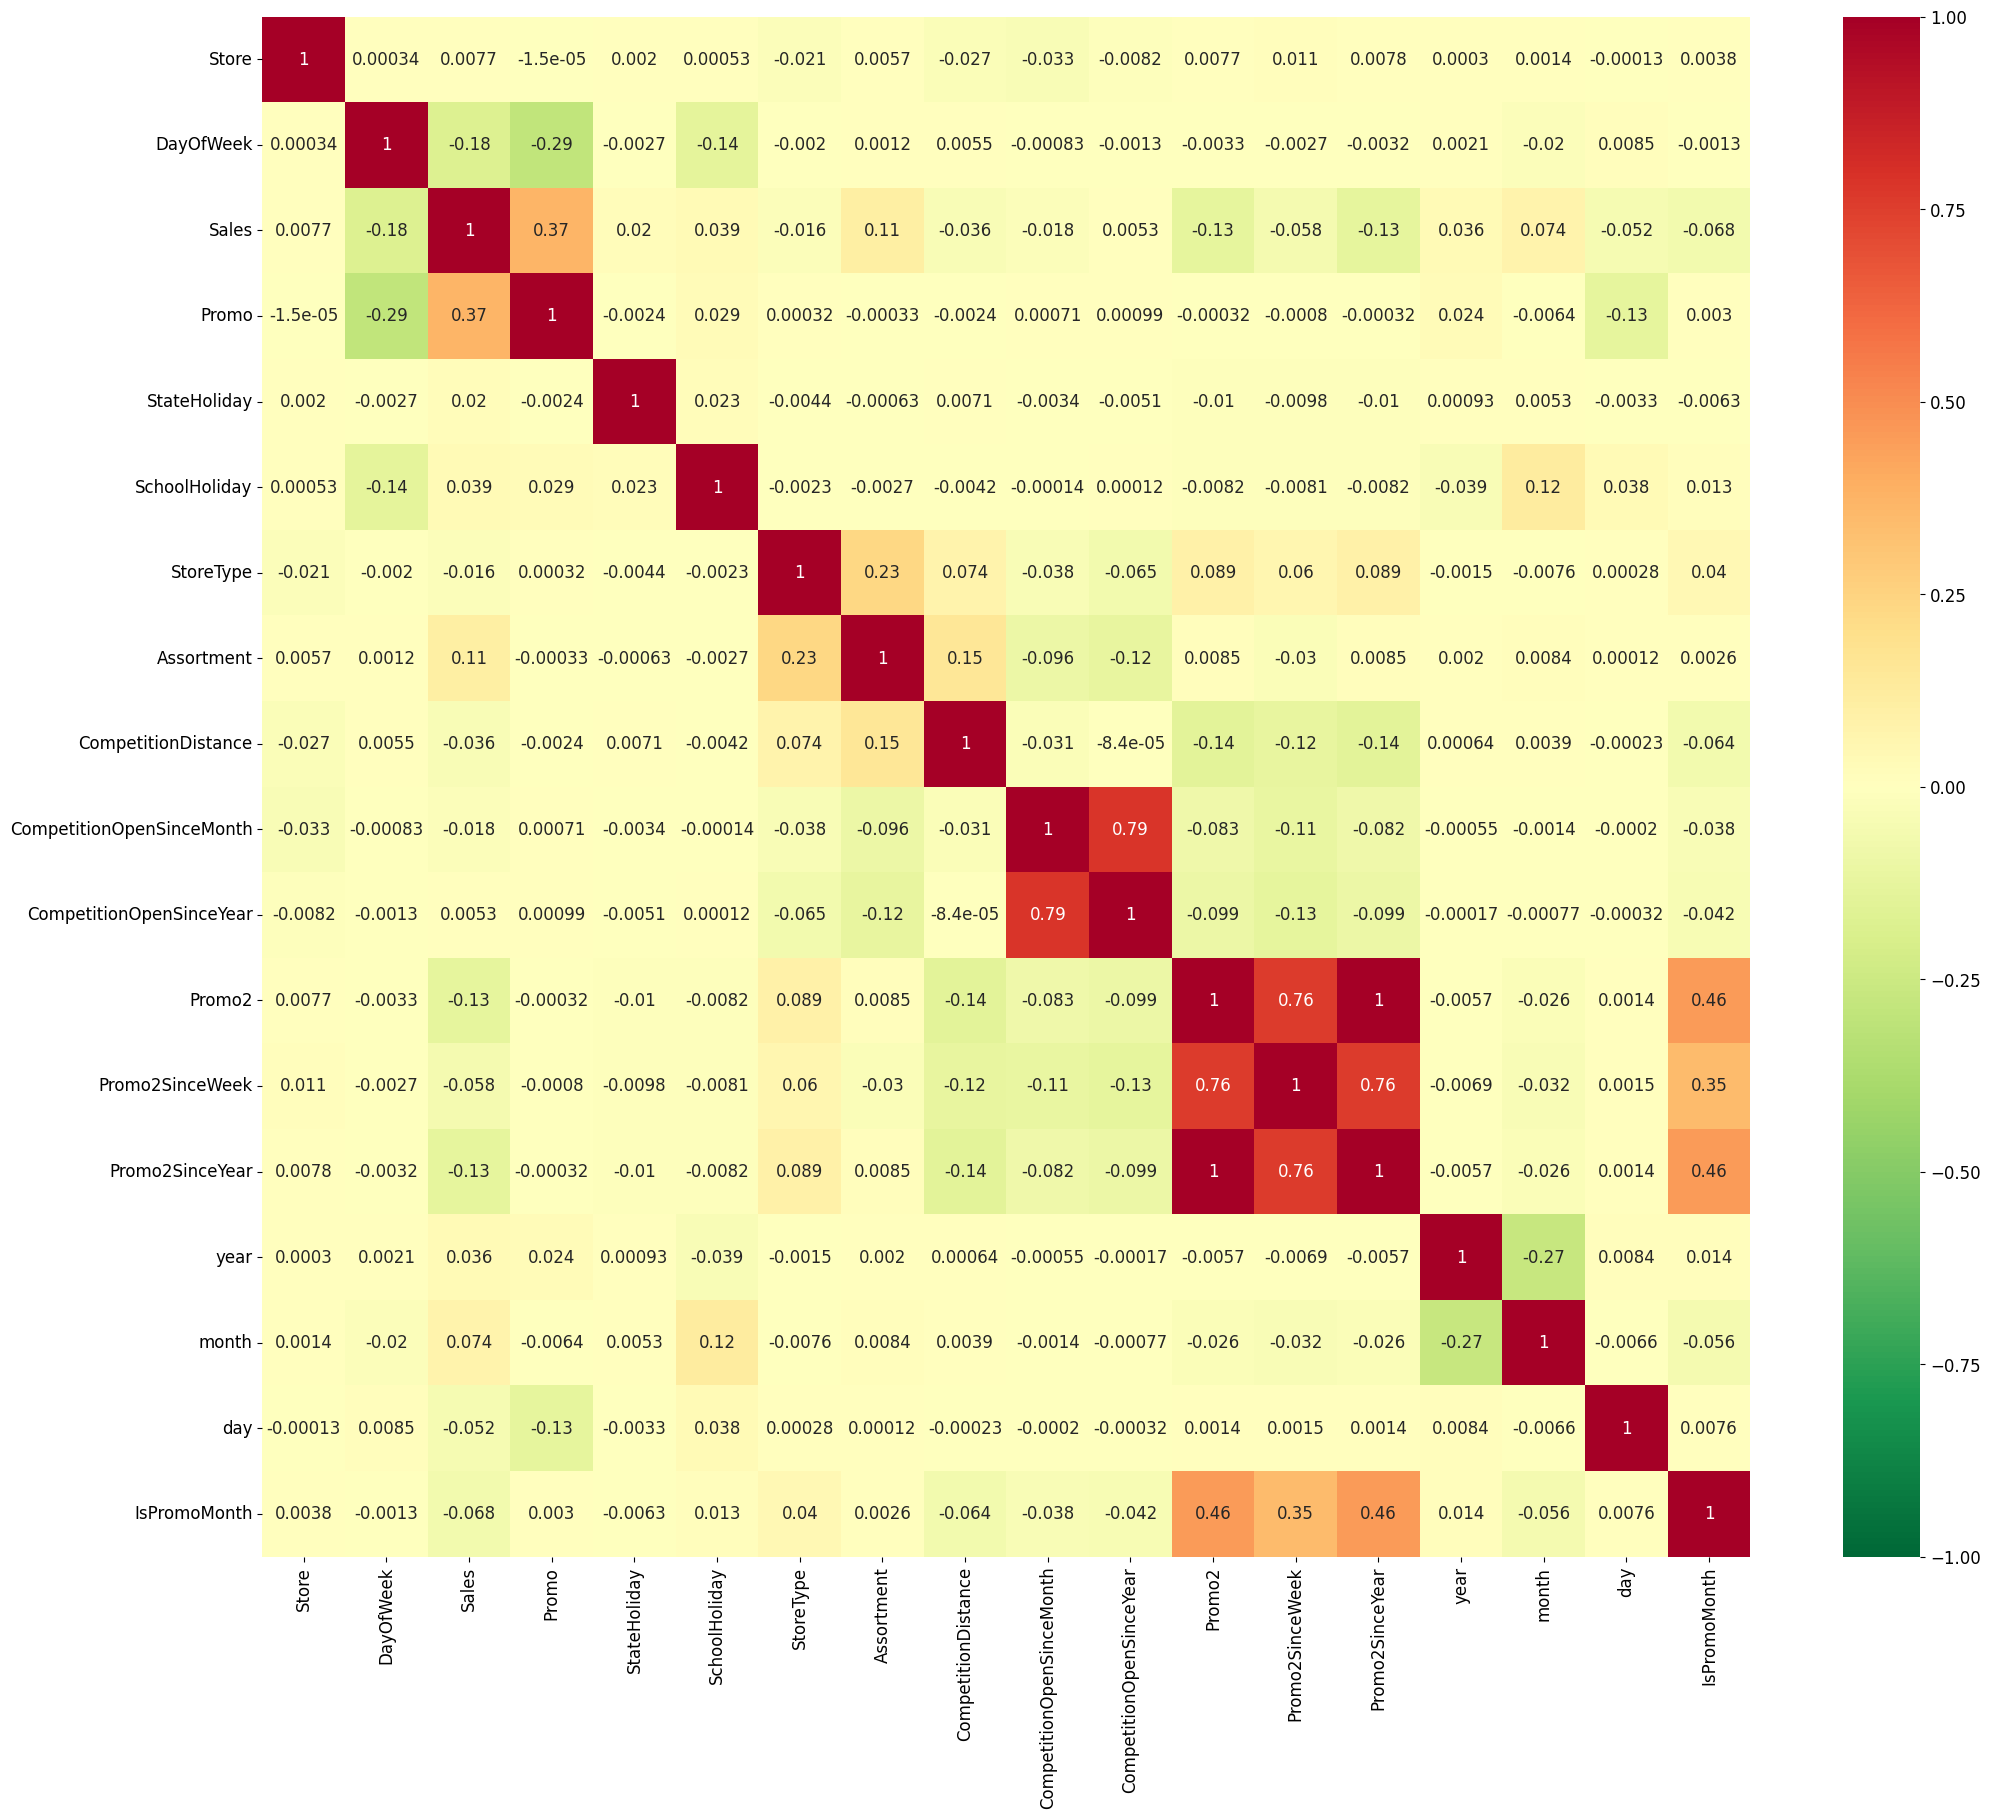

In [114]:
plt.figure(figsize=(24, 20))

plt.rcParams['font.size'] = 12

sns.heatmap(df_train.corr(), cmap='RdYlGn_r', annot=True, vmin=-1, vmax=1)

In [ ]:
y_train = np.log1p(X_train['Sales'])
y_test = np.log1p(X_test['Sales'])

X_train.drop('Sales', axis=1, inplace=True)
X_test.drop('Sales', axis=1, inplace=True)


In [127]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((1 - yhat/y) ** 2))

def rmspe_xg(y, yhat):
    y = np.expm1(y)
    yhat = np.expm1(yhat.get_label())
    return 'rmspe', rmspe(y, yhat)

In [139]:
params = {
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'eta': 0.03,
    'max_depth': 10,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'silent': 1,
    'seed': 10,
}
num_boost_round = 6000

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

evals = [(dtrain, 'train'), (dtest, 'validation')]

gbm = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=100, custom_metric=rmspe_xg, verbose_eval=True)

[0]	train-rmse:0.42006	train-rmspe:0.48860	validation-rmse:0.41137	validation-rmspe:0.49264


D:\miniconda\envs\ptc\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
D:\miniconda\envs\ptc\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	train-rmse:0.41515	train-rmspe:0.48096	validation-rmse:0.40660	validation-rmspe:0.48527
[2]	train-rmse:0.40971	train-rmspe:0.47200	validation-rmse:0.40127	validation-rmspe:0.47647
[3]	train-rmse:0.40418	train-rmspe:0.46363	validation-rmse:0.39553	validation-rmspe:0.46747
[4]	train-rmse:0.40048	train-rmspe:0.45825	validation-rmse:0.39190	validation-rmspe:0.46229
[5]	train-rmse:0.39717	train-rmspe:0.45289	validation-rmse:0.38881	validation-rmspe:0.45739
[6]	train-rmse:0.39350	train-rmspe:0.44755	validation-rmse:0.38542	validation-rmspe:0.45274
[7]	train-rmse:0.38898	train-rmspe:0.44091	validation-rmse:0.38094	validation-rmspe:0.44602
[8]	train-rmse:0.38580	train-rmspe:0.43613	validation-rmse:0.37802	validation-rmspe:0.44182
[9]	train-rmse:0.38152	train-rmspe:0.42980	validation-rmse:0.37352	validation-rmspe:0.43503
[10]	train-rmse:0.37776	train-rmspe:0.42448	validation-rmse:0.36978	validation-rmspe:0.42967
[11]	train-rmse:0.37412	train-rmspe:0.41977	validation-rmse:0.36582	validation-

In [140]:
gbm.save_model('./store_sale_model.json')

In [145]:
X_test.sort_index(inplace=True)
y_test.sort_index(inplace=True)

yhat = gbm.predict(xgb.DMatrix(X_test))
error = rmspe(np.expm1(y_test), np.expm1(yhat))

In [169]:
rmspe(np.expm1(y_test), np.expm1(yhat))

0.1265160019453729

In [152]:
res = pd.DataFrame(data=y_test)
res['Prediction'] = yhat
res = pd.merge(X_test, res, left_index=True, right_index=True)
res['Ratio'] = res['Prediction'] / res['Sales']
res['Error'] = abs(1 - res['Ratio'])
res['weight'] = res['Sales'] / res['Prediction']

In [154]:
res.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Promo2SinceYear,year,month,day,IsPromoMonth,Sales,Prediction,Ratio,Error,weight
0,1,5,1,0,1,3,1,1270.00,9.00,2008.00,...,0.00,2015,7,31,0,8.57,8.60,1.00,0.00,1.00
1,2,5,1,0,1,1,1,570.00,11.00,2007.00,...,2010.00,2015,7,31,1,8.71,8.68,1.00,0.00,1.00
2,3,5,1,0,1,1,1,14130.00,12.00,2006.00,...,2011.00,2015,7,31,1,9.03,9.10,1.01,0.01,0.99
3,4,5,1,0,1,3,3,620.00,9.00,2009.00,...,0.00,2015,7,31,0,9.55,9.46,0.99,0.01,1.01
4,5,5,1,0,1,1,1,29910.00,4.00,2015.00,...,0.00,2015,7,31,0,8.48,8.69,1.02,0.02,0.98


In [155]:
res['Ratio'].mean()

1.000947911139205

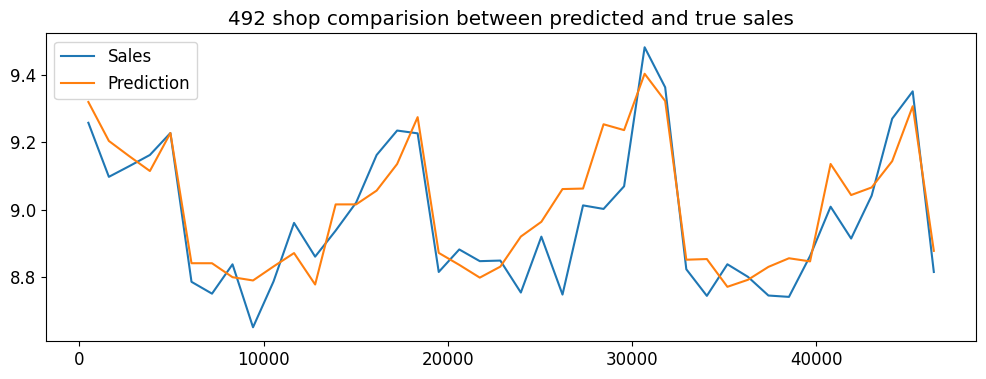

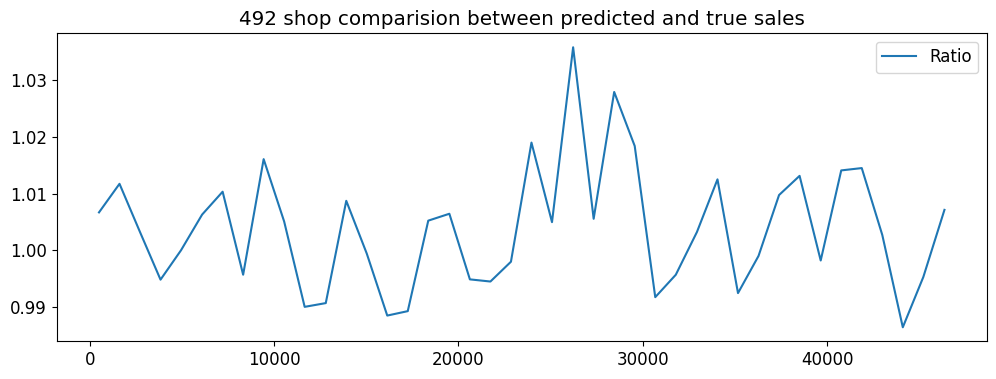

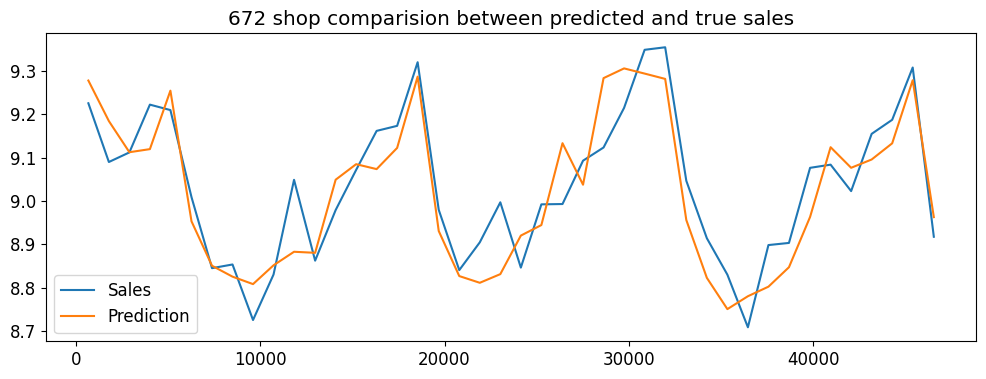

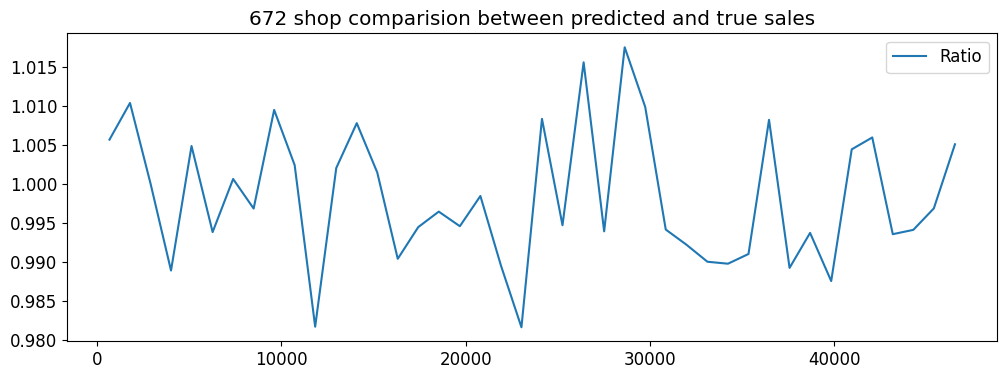

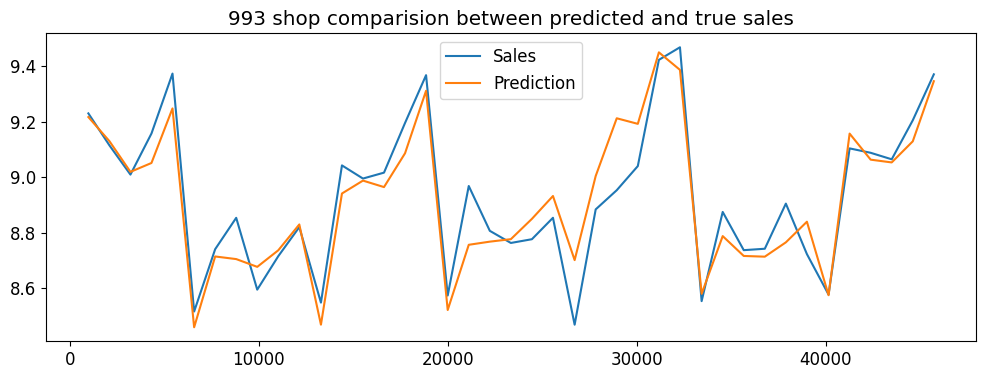

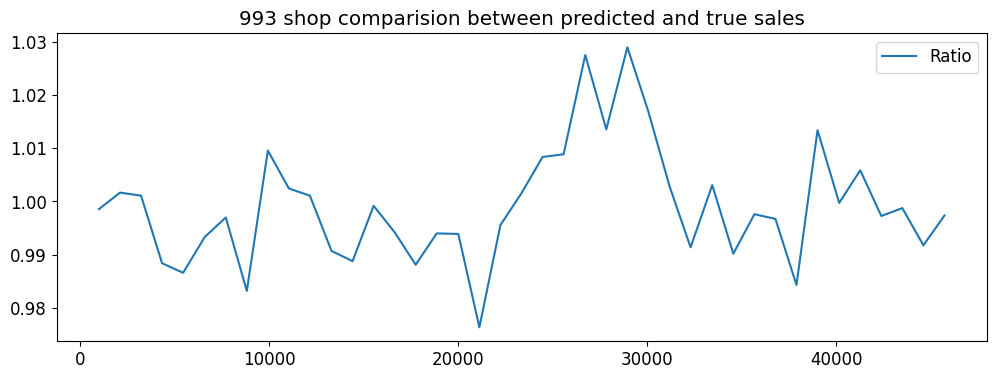

In [157]:
col_1 = ['Sales', 'Prediction']
col_2 = ['Ratio']

shops = np.random.randint(1, 1116, size=3)

for shop in shops:
    cond = res['Store'] == shop
    df1 = pd.DataFrame(data=res[cond], columns=col_1)
    df2 = pd.DataFrame(data=res[cond], columns=col_2)
    df1.plot(title=f'{shop} shop comparision between predicted and true sales', figsize=(12, 4))
    df2.plot(title=f'{shop} shop comparision between predicted and true sales', figsize=(12, 4))


In [159]:
res.sort_values(by=['Error'], ascending=False)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Promo2SinceYear,year,month,day,IsPromoMonth,Sales,Prediction,Ratio,Error,weight
20419,292,5,0,0,0,1,1,1100.00,6.00,2009.00,...,0.00,2015,7,10,0,6.92,8.51,1.23,0.23,0.81
34346,782,5,0,0,0,3,3,5390.00,8.00,2003.00,...,2012.00,2015,6,26,0,7.26,8.57,1.18,0.18,0.85
29981,909,3,1,0,0,1,3,1680.00,0.00,0.00,...,2009.00,2015,7,1,0,8.17,9.58,1.17,0.17,0.85
38929,909,1,0,0,0,1,3,1680.00,0.00,0.00,...,2009.00,2015,6,22,0,10.63,9.17,0.86,0.14,1.16
26606,876,6,0,0,0,1,1,21790.00,4.00,2005.00,...,2015.00,2015,7,4,0,9.60,8.35,0.87,0.13,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,1101,4,1,0,1,4,3,4060.00,9.00,2012.00,...,0.00,2015,7,30,0,9.35,9.35,1.00,0.00,1.00
43125,617,3,1,0,0,1,3,8940.00,0.00,0.00,...,2011.00,2015,6,17,0,8.93,8.93,1.00,0.00,1.00
39394,228,6,0,0,0,4,3,10800.00,0.00,0.00,...,2011.00,2015,6,20,0,9.05,9.05,1.00,0.00,1.00
34436,872,5,0,0,0,1,3,3860.00,9.00,2014.00,...,2015.00,2015,6,26,1,8.93,8.93,1.00,0.00,1.00


In [ ]:
rmspe

In [ ]:
shops = np.arange(1, 1116)
weights1 = []
weights2 = []

for shop in shops:
    cond = res['Store'] == shop
    df1 = pd.DataFrame(res[cond], columns=col_1)

    cond2 = df_test['Store'] == shop
    df2 = pd.DataFrame(df_test[cond2])
    errors = []
    weights = [(0.98 + (i/1000)) for i in range(40)]
    for w in weights:
        error = rmspe(np.expm1(df1['Sales']), np.expm1(df1['Prediction'] * w))
        errors.append(error)

    errors = pd.Series(errors, index=weights)
    index = errors.argmin()
    best_weight = np.array(weights[index])

    weights1.extend(best_weight.repeat(len(df1)).tolist())
    weights2.extend(best_weight.repeat(len(df2)).tolist())

X_test.sort_values(by='Store')
X_test['weights1'] = weights1 
X_test = X_test.sort_index()
weights1 = X_test['weights1']
# X_test.drop('weights1', axis=1)

df_test.sort_values(by='Store')
df_test['weights2'] = weights2 
df_test = df_test.sort_index()
weights2 = df_test['weights2']
# df_test.drop('weights2', axis=1)

In [176]:
X_test.drop('weights1', axis=1, inplace=True)
df_test.drop('weights2', axis=1, inplace=True)

In [177]:
yhat_new = yhat * weights1

rmspe(np.expm1(y_test), np.expm1(yhat_new))

0.12847874380629642

In [178]:
df_test.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'year', 'month', 'day',
       'IsPromoMonth'],
      dtype='object')

In [179]:
test = xgb.DMatrix(df_test)
y_pred = gbm.predict(test)

In [181]:
np.expm1(y_pred)

array([ 4029.283,  7316.923,  8626.671, ...,  6705.58 , 23270.352,
        8367.129], dtype=float32)

In [185]:
result = pd.DataFrame({'ID': np.arange(1, 41089), 'Sales': np.expm1(y_pred)})
result.to_csv('./result1.csv', index=False)

In [186]:
result = pd.DataFrame({'ID': np.arange(1, 41089), 'Sales': np.expm1(y_pred * weights2)})
result.to_csv('./result2.csv', index=False)